In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_breast_cancer, make_circles, make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb, mnist, reuters
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.models import load_model
from keras.layers import Dense

2023-12-19 09:39:43.469384: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 09:39:43.525500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 09:39:43.525538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 09:39:43.527132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 09:39:43.536618: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 09:39:43.536933: I tensorflow/core/platform/cpu_feature_guard.cc:1

# El perceptrón

El perceptrón es un sistema muy simple y podemos programarlo sin gran dificultad. Comenzaremos mostrando cómo un perceptrón va evolucionando hasta aprender a clasificar los datos. El perceptrón realiza la predicción y actualiza los pesos acorde a lo que se define a continuación:

1. **Predicción:** el valor de la clase ($y$) se decide acorde a la siguiente fórmula.

$$
y = \begin{cases}
    1 & \text{si } \sum_{i=1}^{n} w_i x_i + b > 0 \\
    0 & \text{en otro caso}
\end{cases}
$$

Donde:
- $y$ es la salida (predicción) del perceptrón.
- $w_i$ son los pesos asociados a cada entrada $x_i$.
- $b$ es el sesgo (bias).
- $n$ es el número de características de entrada.

2. **Actualización de pesos:** Una vez predicha la clase se actualiza cada peso de la red ($w_i$) acorde a lo siguiente:
$$ w_i = w_i + \text{tasa de aprendizaje} \times (y_{\text{real}} - y_{\text{predicha}}) \times x_i $$

Donde:
- $w_i$ se actualiza para cada característica de entrada.
- $y_{\text{real}}$ es la etiqueta real del ejemplo de entrenamiento.
- $y_{\text{predicha}}$ es la predicción del perceptrón.

El sesgo también se actualiza de manera similar:
$$b = b + \text{tasa de aprendizaje} \times (y_{\text{real}} - y_{\text{predicha}})$$

A continuación daremos una implementación del perceptrón donde:

- `self.weights` representa $w_i$ (los pesos).
- `self.weights[0]` representa el sesgo $b$.
- `self.predict(inputs)` calcula $y_{\text{predicha}}$.
- `label` representa $y_{\text{real}}$.
- La actualización de pesos se realiza en la función `train` del perceptrón.


In [2]:
class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, max_epochs=100):
        self.weights = np.random.rand(input_size + 1)
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return 1 if summation > 0 else 0

    def train(self, training_inputs, labels, visualize=False):
        fig, axes = plt.subplots(1, self.max_epochs, figsize=(20, 6))  # Crear una fila de subfiguras
        fig.suptitle('Perceptrón - Evolución por Época', y=1.02)

        for epoch in range(self.max_epochs):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

            # Verificar si se ha alcanzado la convergencia antes de mostrar la subfigura
            if visualize and all(self.predict(inputs) == label for inputs, label in zip(training_inputs, labels)):
                print(f'Convergencia alcanzada en la época {epoch + 1}')
                break

            if visualize:
                # Visualizar la frontera de decisión después de cada época en una subfigura
                self.plot_decision_boundary(training_inputs, labels, axes[epoch], epoch + 1, self.max_epochs)

        plt.tight_layout()
        plt.show()

    def plot_decision_boundary(self, inputs, labels, ax, epoch, max_epochs):
        ax.clear()
        ax.scatter(inputs[:, 0], inputs[:, 1], c=labels, cmap='viridis')
        ax.set_xlabel('Característica 1')
        ax.set_ylabel('Característica 2')

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = np.array([self.predict([x, y]) for x, y in np.c_[xx.ravel(), yy.ravel()]])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
        ax.set_title(f'Época {epoch}/{max_epochs}')

Probaremos esta función para un conjunto de datos linealmente separables:

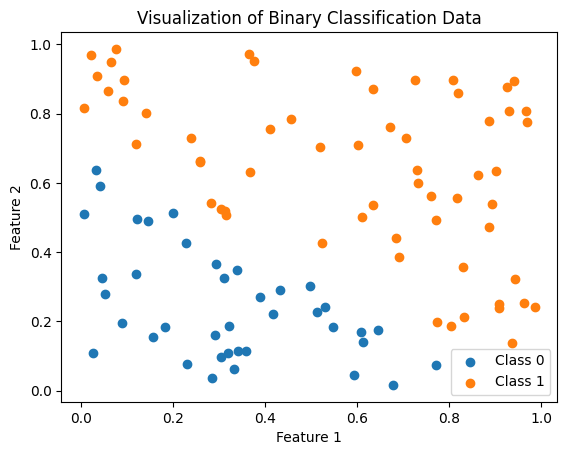

In [6]:
np.random.seed(42)
data = np.random.rand(100, 2)
labels = (2 * data[:, 0] + 3 * data[:, 1] > 2).astype(int)

# Dividir los datos en dos conjuntos según la etiqueta
class_0 = data[labels == 0]
class_1 = data[labels == 1]

# Visualizar los datos
plt.scatter(class_0[:, 0], class_0[:, 1], marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], marker='o', label='Class 1')

# Etiquetas y leyenda
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Binary Classification Data')
plt.legend()

# Mostrar el gráfico
plt.show()

El objetivo sería que la red neuronal llegara a aprender la siguiente división:

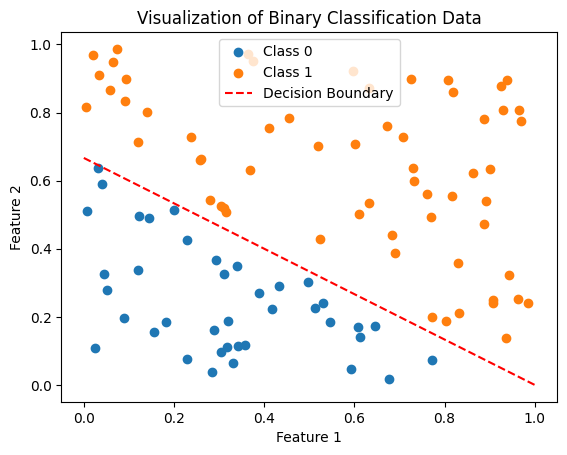

In [7]:
np.random.seed(42)
data = np.random.rand(100, 2)
labels = (2 * data[:, 0] + 3 * data[:, 1] > 2).astype(int)

# Dividir los datos en dos conjuntos según la etiqueta
class_0 = data[labels == 0]
class_1 = data[labels == 1]

# Visualizar los datos
plt.scatter(class_0[:, 0], class_0[:, 1], marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], marker='o', label='Class 1')

# Dibujar la frontera de decisión (línea recta en este caso)
x_decision_boundary = np.linspace(0, 1, 100)
y_decision_boundary = (2 - 2 * x_decision_boundary) / 3
plt.plot(x_decision_boundary, y_decision_boundary, color='red', linestyle='--', label='Decision Boundary')

# Etiquetas y leyenda
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Binary Classification Data')
plt.legend()

# Mostrar el gráfico
plt.show()

Veámos cómo se computa utlizando la clase perceptrón implementada:

Convergencia alcanzada en la época 5


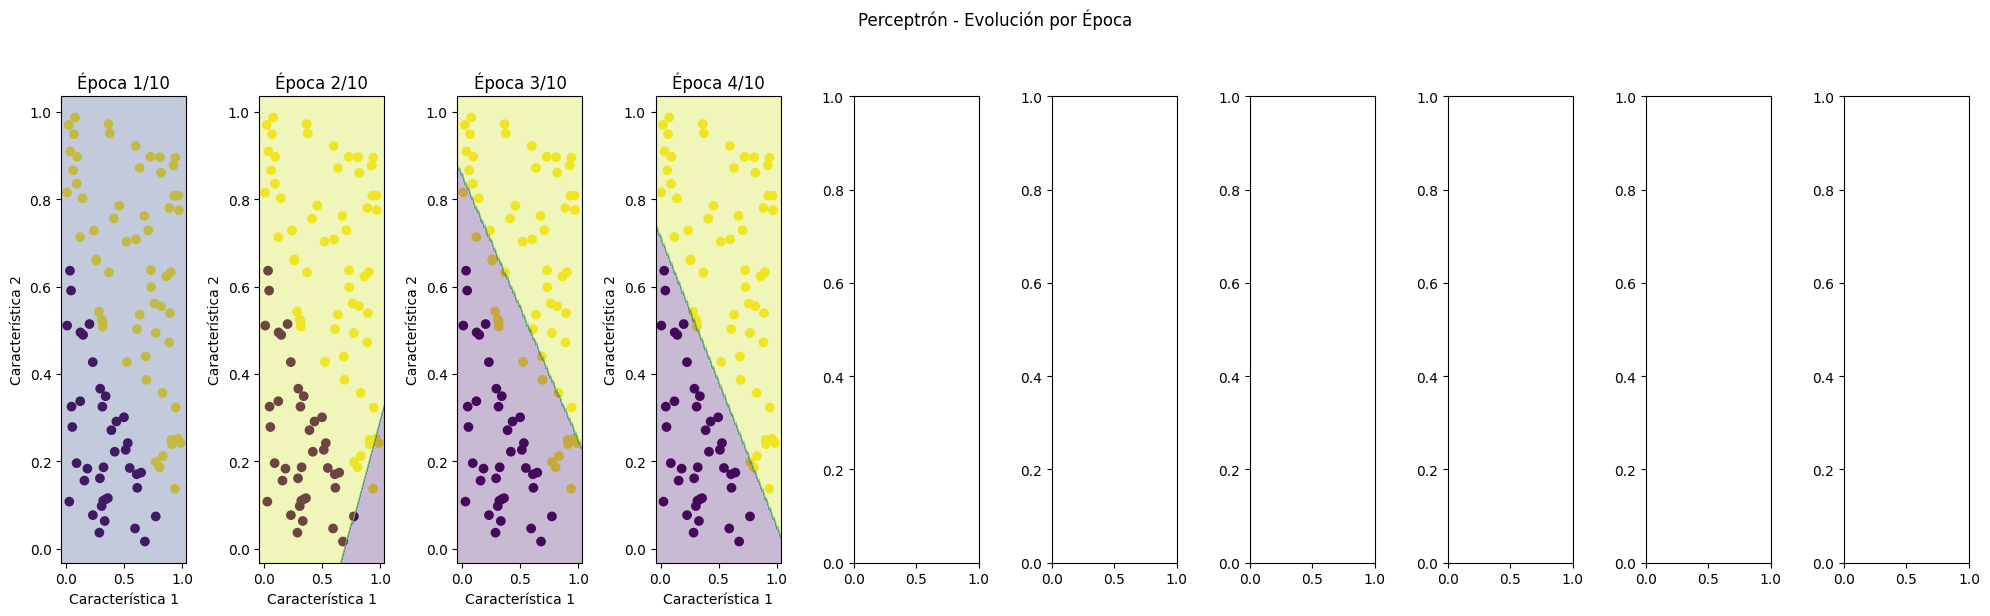

In [8]:
# Crear y entrenar el perceptrón con visualización
perceptron = Perceptron(input_size=2, max_epochs=10)
perceptron.train(data, labels, visualize=True)

Ahora probemos en un conjunto de datos diferente. Es importante observar que la inicialización aleatoria de las variables puede implicar que la red tarde más o menos tiempo en converger.

In [9]:
# Generar un conjunto de datos más desafiante
data, labels = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

Veámos como, dependiendo de la inicialización aleatoria de los pesos, la red tarda más o menos en realizar el aprendizaje:

Convergencia alcanzada en la época 9


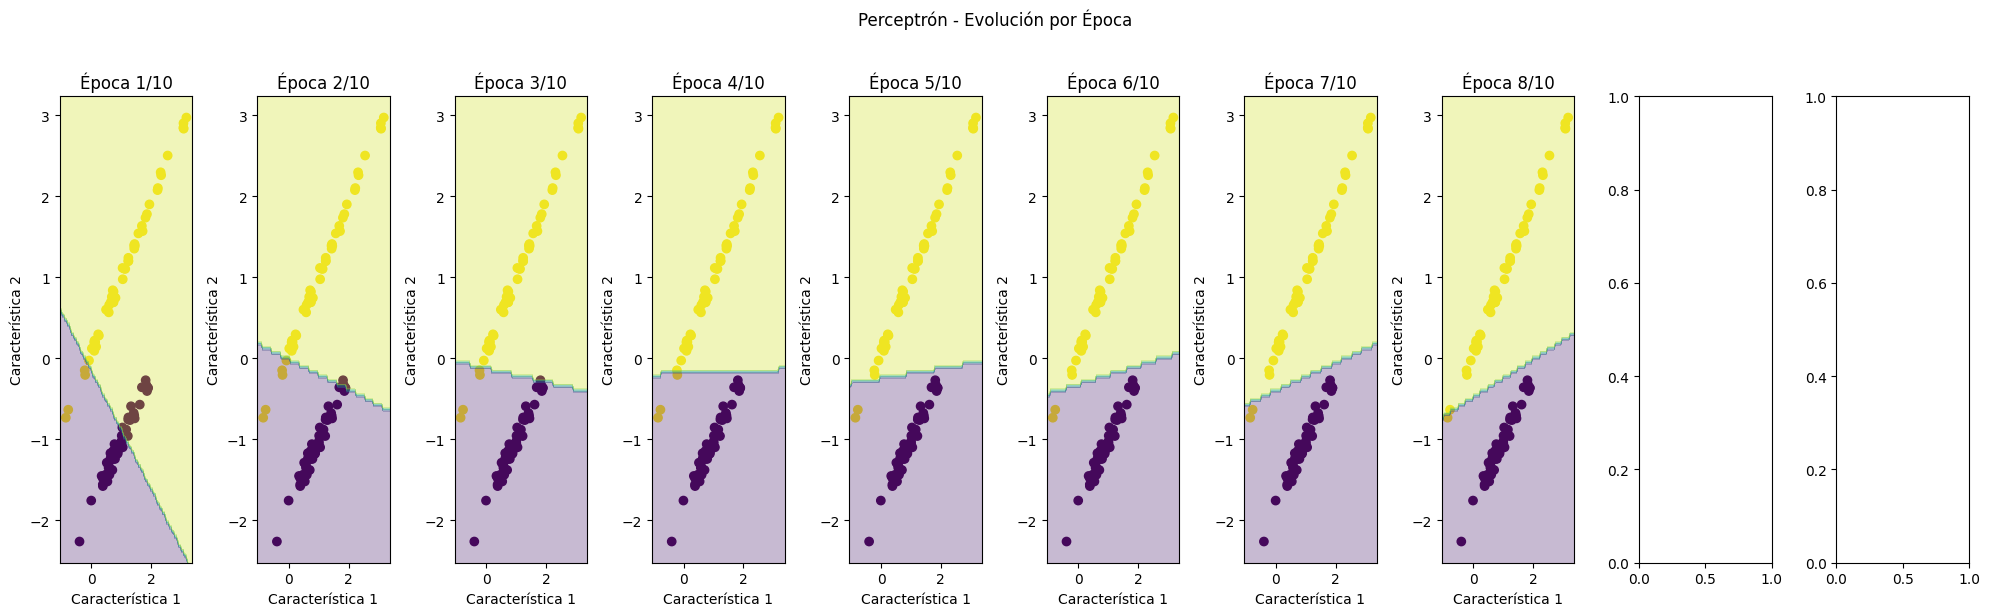

In [10]:
np.random.seed(1)
perceptron = Perceptron(input_size=2, max_epochs=10)
perceptron.train(data, labels, visualize=True)

Convergencia alcanzada en la época 2


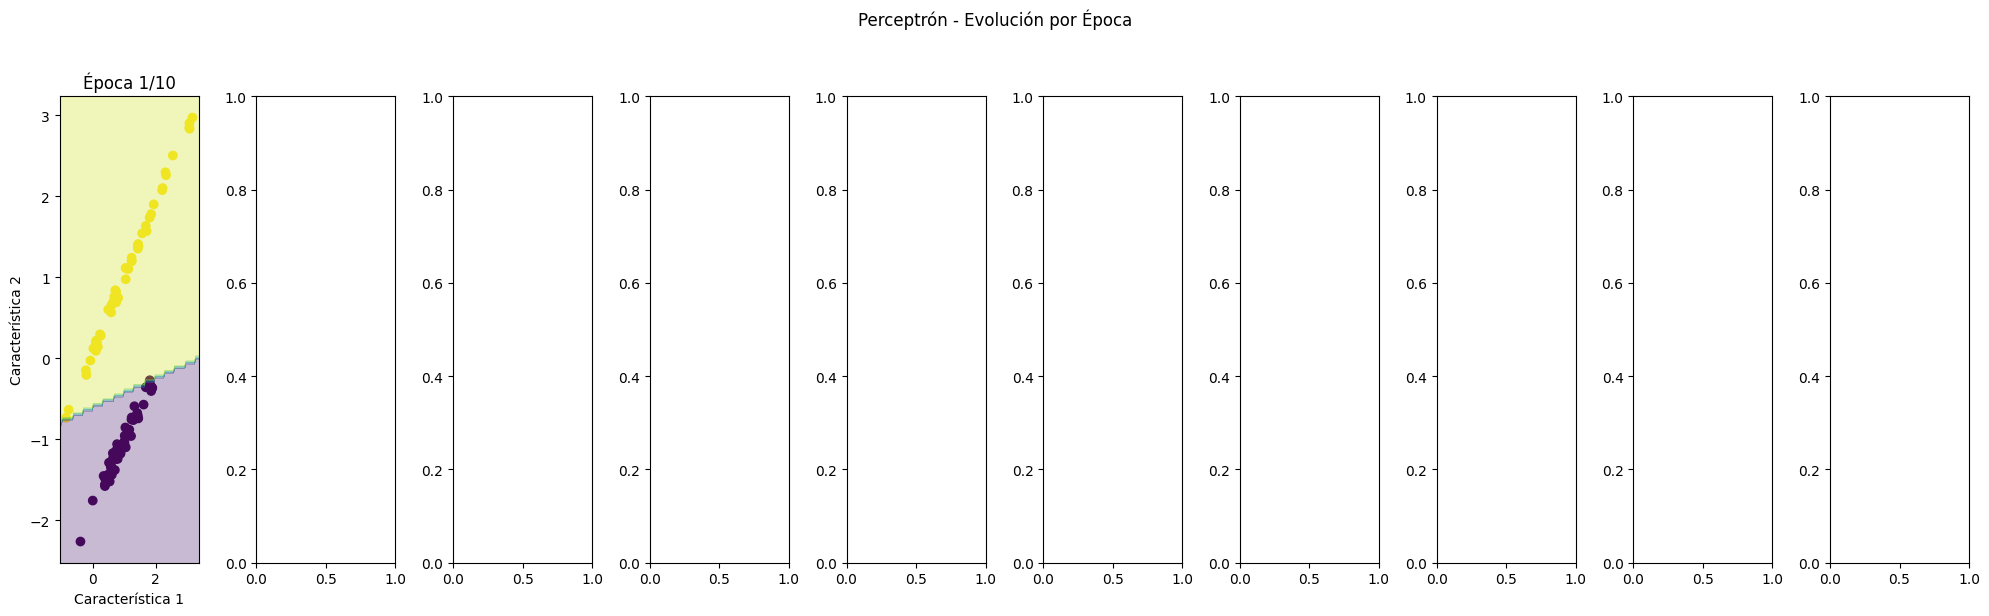

In [11]:
np.random.seed(2)
perceptron = Perceptron(input_size=2, max_epochs=10)
perceptron.train(data, labels, visualize=True)

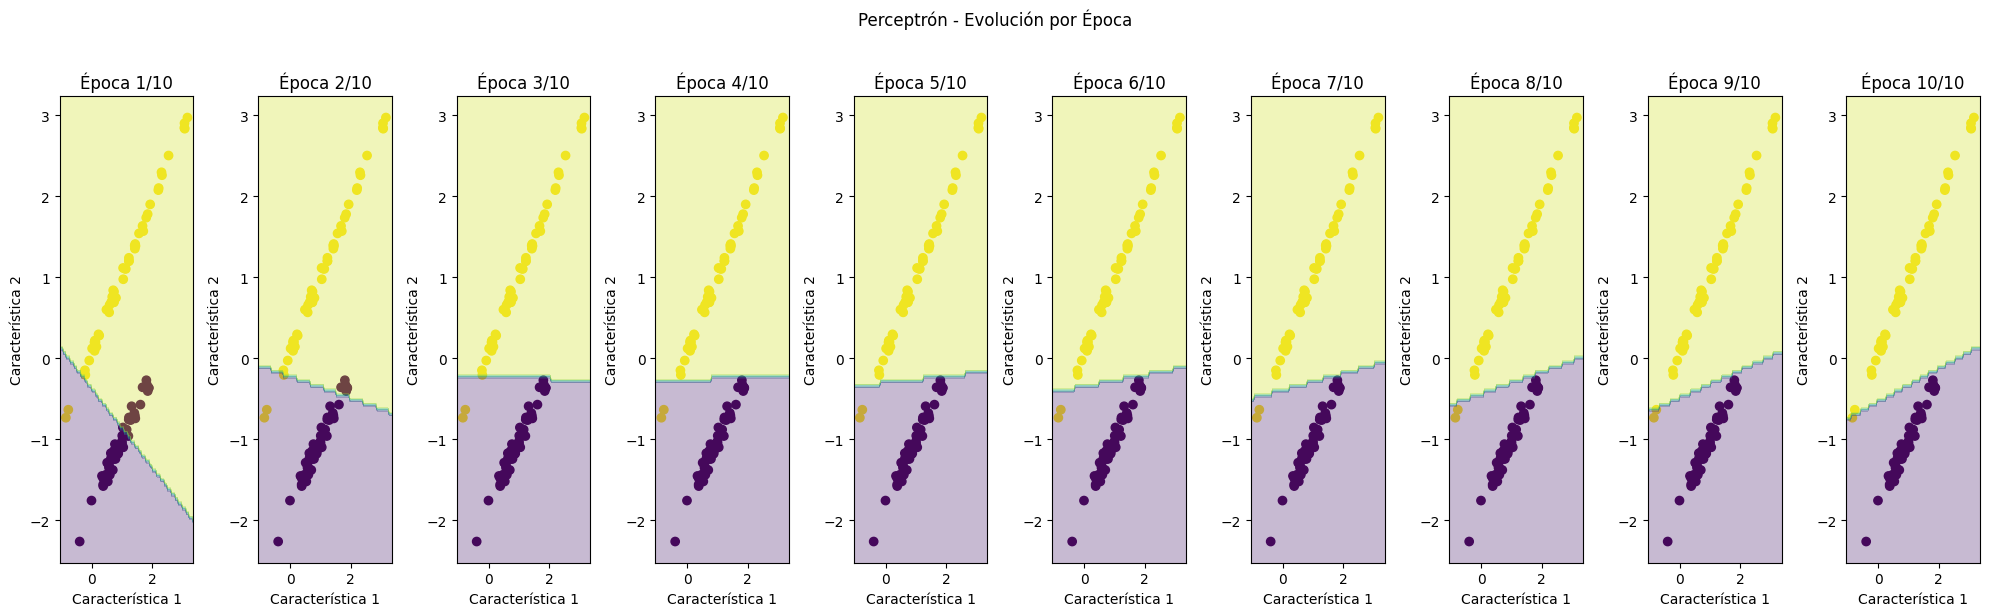

In [12]:
np.random.seed(3)
perceptron = Perceptron(input_size=2, max_epochs=10)
perceptron.train(data, labels, visualize=True)

# Introducción a `keras`

Replicar un perceptrón en Keras es bastante sencillo, ya que como hemos visto el perceptrón es una red neuronal con una sola capa. En el siguiente ejemplo utilizaremos `Sequential()` para crear un modelo en el que pueden añadirse capas seucnecialmente. Como el perceptrón solo tiene una capa, esta se añade utilizando `add(Dense(...))` con una sola unidad. En este caso utilizaremos una función de activación sigmoide, ya que estamos realizando una tarea de clasificación binaria.

Luego, el modelo se compila con un optimizador (utilizaremos Gradiente Descendente Estocástico), una función de pérdida (en este caso entropía cruzada binaria, adecuada para clasificación binaria), y una métrica (accuracy en este caso). Finalmente, el modelo se entrena con los datos de entrada y etiquetas, y se evalúa su rendimiento en los mismos datos.

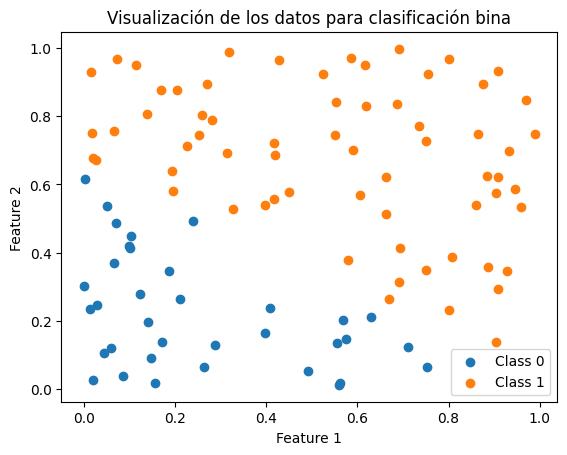

In [13]:
# Datos de entrada
np.random.seed(1)
data = np.random.rand(100, 2)
labels = (2 * data[:, 0] + 3 * data[:, 1] > 2).astype(int)

# Dividir los datos en dos conjuntos según la etiqueta
class_0 = data[labels == 0]
class_1 = data[labels == 1]

# Visualizar los datos
plt.scatter(class_0[:, 0], class_0[:, 1], marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], marker='o', label='Class 1')

# Etiquetas y leyenda
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualización de los datos para clasificación bina')
plt.legend()

# Mostrar el gráfico
plt.show()

In [14]:
# Crear un modelo secuencial (perceptrón)
perceptron_model = Sequential()

# Añadir una capa densa (totalmente conectada) con una sola unidad y función de activación sigmoid
perceptron_model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

# Compilar el modelo con un optimizador (gradiente descendente estocástico), función de pérdida y métrica
perceptron_model.compile(optimizer=SGD(learning_rate=0.01),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Entrenar el modelo
perceptron_model.fit(data, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 1s 104ms/step - loss: 1.0589 - accuracy: 0.3375 - val_loss: 1.0021 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0503 - accuracy: 0.3375 - val_loss: 0.9951 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0424 - accuracy: 0.3375 - val_loss: 0.9879 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0341 - accuracy: 0.3375 - val_loss: 0.9810 - val_accuracy: 0.4000
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0262 - accuracy: 0.3250 - val_loss: 0.9739 - val_accuracy: 0.4000
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0182 - accuracy: 0.3250 - val_loss: 0.9676 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0110 - accuracy: 0.3250 - val_loss: 0.9616 - val_accuracy: 0.4000
Epoch 8/100
3/3 [==

La salida que se ve durante el entrenamiento contiene la siguiente información:

- Epoch x/epochs: Indica la época en la que estás. Durante cada época, el modelo pasa por todos los datos de entrenamiento una vez.
- x/batches: Indica el número de lotes (batches) que llevas completado en cada época y se actualiza dinámicamente. Mediante
[==============================], la barra de progreso visual indica cuánto del total de lotes se ha completado en la época actual.
- xs xxms/step: Indica que, en promedio, cada paso (o lote) ha tomado xx milisegundos y que la época en su totalidad ha tomado x segundos.
- loss: El valor de la función de pérdida en el conjunto de entrenamiento al final de esta época. Este valor mide cuánto se desvían las predicciones del modelo respecto a las etiquetas reales.
- accuracy: La precisión del modelo en el conjunto de entrenamiento al final de esta época. Este valor indica la proporción de ejemplos de entrenamiento que se clasificaron correctamente.
- val_loss: El valor de la función de pérdida en el conjunto de validación al final de esta época. Es similar a la pérdida en el conjunto de entrenamiento, pero se evalúa en un conjunto de datos no utilizado para el entrenamiento.
- val_accuracy: La precisión en el conjunto de validación al final de esta época. Al igual que la precisión en el conjunto de entrenamiento, indica la proporción de ejemplos de validación que se clasificaron correctamente.

In [15]:
perceptron_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


La red neuronal tiene la forma que se muestra a continuación. Vemos que las capas contienen información del tipo `(None, 2)`, que representa el tamaño del lote (batch size) y el número de neuronas en esa capa. El `None` en la forma indica que la dimensión correspondiente puede tener cualquier tamaño. En el contexto del tamaño del lote (batch size), significa que el modelo puede aceptar datos de entrada con tamaños de lote variables. Por este motivo, durante el entrenamiento y la predicción, puedes alimentar al modelo lotes de diferentes tamaños, y la red se adaptará en consecuencia. El tamaño real del lote se determina durante la ejecución. El número 2 en (None, 2) representa la cantidad de neuronas en esa capa específica.

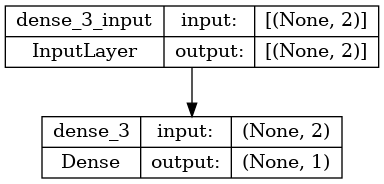

In [16]:
plot_model(perceptron_model, show_shapes=True, show_layer_names=True)

In [17]:
# Evaluar el modelo en datos de prueba
accuracy = perceptron_model.evaluate(data, labels)[1]
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.6000
Accuracy: 0.6000000238418579


Normalmente, querrás evaluar el modelo en un conjunto de datos de prueba separado para obtener una medida más realista de su rendimiento en datos no vistos:

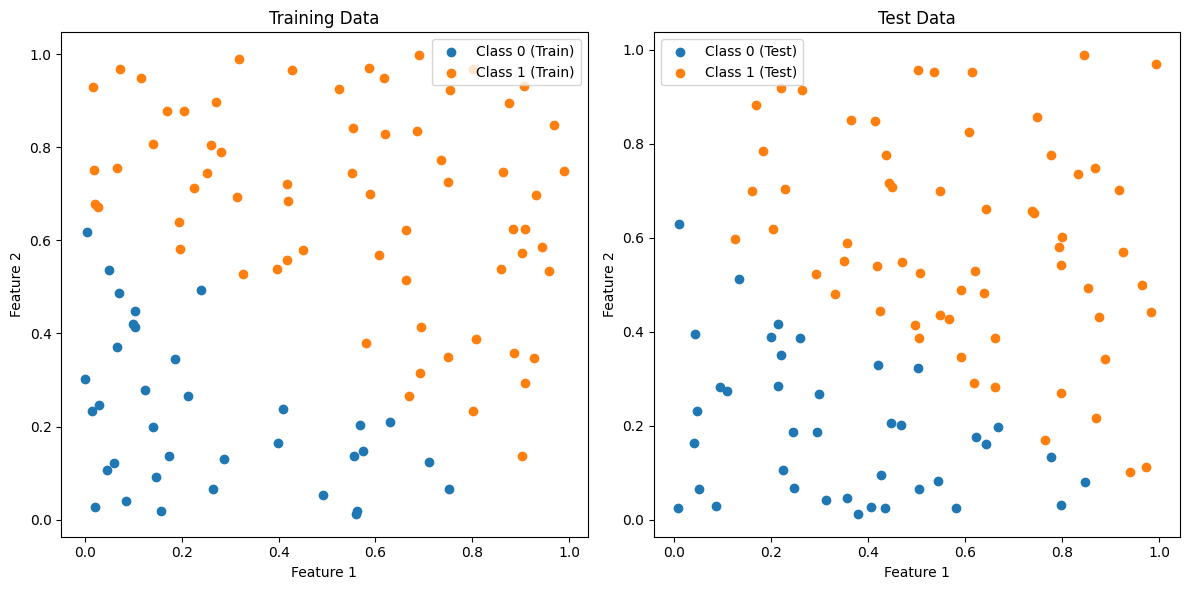

In [18]:
# Datos de entrada
np.random.seed(2)
test_data = np.random.rand(100, 2)
test_labels = (2 * test_data[:, 0] + 3 * test_data[:, 1] > 2).astype(int)

# Dividir los datos en dos conjuntos según la etiqueta
class_0_train = data[labels == 0]
class_1_train = data[labels == 1]

class_0_test = test_data[test_labels == 0]
class_1_test = test_data[test_labels == 1]

# Configurar subfiguras
plt.figure(figsize=(12, 6))

# Subfigura 1: Datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(class_0_train[:, 0], class_0_train[:, 1], marker='o', label='Class 0 (Train)')
plt.scatter(class_1_train[:, 0], class_1_train[:, 1], marker='o', label='Class 1 (Train)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data')
plt.legend()

# Subfigura 2: Datos de prueba
plt.subplot(1, 2, 2)
plt.scatter(class_0_test[:, 0], class_0_test[:, 1], marker='o', label='Class 0 (Test)')
plt.scatter(class_1_test[:, 0], class_1_test[:, 1], marker='o', label='Class 1 (Test)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test Data')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [19]:
# Evaluar el modelo en el conjunto de test
accuracy = perceptron_model.evaluate(test_data, test_labels)[1]
print(f'Accuracy on test set: {accuracy}')

4/4 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5700
Accuracy on test set: 0.5699999928474426


Muchas veces estos modelos requerirán un tiempo de ejecución elevado y no podremos permitirnos entrenarlos dos veces, por lo que en estas situaciones es crucial persistir el modelo generado. Una de las formas en las que podemos hacer esto es generando un archivo `.keras` (también puede exportarse a otros formatos como por ejemplo (`.h5`) utilizando:

In [20]:
perceptron_model.save("modelo.keras")

Estos archivos pueden cargarse luego ejecutando:

In [21]:
modelo_cargado = load_model("modelo.keras")
modelo_cargado.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Desglosando Keras

Keras es una biblioteca de alto nivel para construir y entrenar modelos de redes neuronales en Python. Está diseñada para ser fácil de usar, modular y extensible. Keras proporciona una interfaz de alto nivel para construir modelos neuronales, mientras que internamente utiliza otras bibliotecas como TensorFlow para realizar cálculos eficientes.

## Definición del modelo

En Keras, los **modelos** se definen como una secuencia de capas. El modelo más común es el modelo secuencial, que se crea mediante la clase `Sequential`. Como su propio nombre indica, puedes agregar capas a este modelo de manera secuencial.

```{python}
from keras.models import Sequential
from keras.layers import Dense

# Crear un modelo secuencial
model = Sequential()

# Agregar capas al modelo
model.add(Dense(units=64, activation='relu', input_dim=input_size))
model.add(Dense(units=1, activation='sigmoid'))
```

Las capas son los bloques de construcción fundamentales en un modelo de Keras. Puedes usar diferentes tipos de capas, como capas densas (totalmente conectadas), capas de convolución, capas recurrentes, etc.

```{python}
from keras.layers import Dense, Conv2D, LSTM
```

Las funciones de activación se aplican a la salida de una capa y le dan no linealidad al modelo. Algunas funciones de activación comunes son ReLU, Sigmoid y Tanh.

```{python}
from keras.activations import relu, sigmoid
```

### Funciones de activación

La función de activación de una capa en una red neuronal desempeña un papel crucial en la capacidad del modelo para aprender y representar patrones en los datos. En concreto en la definición de la arquitectura del código anterior hemos utilizado dos capas para definir el modelo y cada una de ellas tiene una función de activación distinta.

- En la primera capa `Dense` con activación `relu`: La función de activación Rectified Linear Unit es comúnmente utilizada en capas ocultas de una red neuronal ya que es simple pero efectiva. Matemáticamente, ReLU se define como $$f(x) = \max(0, x)$$ lo cual significa que si la entrada es positiva, se pasa directamente como salida; si es negativa, la salida es cero. La función ReLU ayuda a la red a aprender representaciones no lineales. Esto significa que introduce no linealidades en las capas ocultas, permitiendo al modelo aprender representaciones más complejas de los datos.
- En la segunda capa `Dense` con activación `sigmoid`: Esta función de activación se utiliza comúnmente en la capa de salida de una red neuronal cuando estamos realizando una tarea de **clasificación binaria**. La función sigmoid produce valores en el rango de 0 a 1 y es útil para modelar la probabilidad de que una instancia pertenezca a la clase positiva. Matemáticamente, la función sigmoid es $$ f(x) = \frac{1}{1 + e^{-x}} $$ La función sigmoid en la capa de salida es apropiada para tareas de **clasificación binaria**, ya que produce una salida entre 0 y 1 que puede interpretarse como la probabilidad de pertenecer a la clase positiva.

Estas elecciones de funciones de activación son comunes, pero dependiendo del problema, pueden explorarse otras funciones de activación como `tanh` o `softmax`. Algunos ejemplos de situaciones en las que podrías preferir utilizarlas son:

- Función de activación `tanh`:
   - Escalado a valores entre -1 y 1: La función `tanh` (tangente hiperbólica) escala las entradas a valores entre -1 y 1. Puede ser útil en capas ocultas de la red cuando se quiere que las salidas estén en un rango simétrico alrededor de cero.
   - Problemas con datos centrados alrededor de cero: Cuando tus datos tienen una media cercana a cero, `tanh` puede ayudar a la convergencia más rápida de la red.

```{python}
   from keras.layers import Dense
   model.add(Dense(units=64, activation='tanh', input_dim=input_size))
```

2. Función de Activación `softmax`: se utiliza comúnmente en la capa de salida de redes neuronales para problemas de **clasificación multiclase**. Produce una distribución de probabilidad sobre todas las clases, lo que es útil cuando tienes más de dos clases en tu problema. Esta función asegura que la suma de las salidas sea igual a 1, lo que facilita la interpretación como probabilidades.

```{python}
   from keras.layers import Dense
   model.add(Dense(units=num_classes, activation='softmax'))
```

La elección de la función de activación depende siempre del problema específico y de las características de los datos. Es necesario experimentar con diferentes funciones de activación y evaluar su rendimiento en un conjunto de validación para determinar cuál funciona mejor en cada caso particular.



## Compilación del modelo

Después de definir el modelo, necesitas **compilarlo** con un **optimizador**, una **función de pérdida** y, opcionalmente, métricas. Esto se realiza utilizando el método compile.

```{python}
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

```

De nuevo, la elección del optimizador y la función de pérdida en un modelo de red neuronal depende del tipo de problema que estás abordando. En el caso de un problema de clasificación binaria, una combinación comúnmente utilizada es `adam` como optimizador y `binary_crossentropy` como función de pérdida, aunque también son comunes otros optimizadores como `rmspop`.

- El optimizador Adam es una variante del descenso de gradiente estocástico que combina las ideas del descenso de gradiente con momentum y el método de estimación adaptativa de la tasa de aprendizaje (Adagrad). Es una opción sólida para comenzar en muchos casos y tiende a converger rápidamente.
- La función de pérdida de entropía cruzada binaria es apropiada para problemas de clasificación binaria, donde la salida de la red es una probabilidad entre 0 y 1. Esta función de pérdida mide la discrepancia entre las predicciones del modelo y las etiquetas reales. Para problemas de clasificación binaria, es una elección común debido a su capacidad para penalizar de manera efectiva las predicciones incorrectas.

### Optimizadores

Entre los optimizadores más comunes en Keras encontramos:

- SGD (Stochastic Gradient Descent) `sgd`: Este es el optimizador de descenso de gradiente estocástico básico. Es simple y a menudo se utiliza como punto de partida.

```
from keras.optimizers import SGD
optimizer = SGD(lr=0.01, momentum=0.9)
```

- Adam (Adaptive Moment Estimation) `adam`: Combina conceptos de RMSprop y momento. Es ampliamente utilizado debido a su rendimiento general.

```
from keras.optimizers import Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
```

- RMSprop (Root Mean Square Propagation) `rmsprop`: Ajusta la tasa de aprendizaje individualmente para cada parámetro, ayudando en problemas donde las características de los datos pueden variar en magnitud.

```
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001)
```

- Adagrad `adagrad`: Ajusta la tasa de aprendizaje para cada parámetro según la frecuencia con la que ese parámetro ha sido actualizado en el pasado.

```
from keras.optimizers import Adagrad
optimizer = Adagrad(lr=0.01)
```

- Adadelta `adadelta`: Similar a Adagrad, pero intenta resolver algunos problemas relacionados con la tasa de aprendizaje que disminuye rápidamente.

```
from keras.optimizers import Adadelta
optimizer = Adadelta()
```

- Nadam `nadam`: Una variante de Adam que utiliza Nesterov Accelerated Gradient.

```
from keras.optimizers import Nadam
optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
```

### Funciones de pérdida

Para problemas de clasificación en Keras, las funciones de pérdida más comunes son:

- Binary Crossentropy `binary_crossentropy`: Para problemas de clasificación binaria.

```
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

- Categorical Crossentropy `categorical_crossentropy`: Para problemas de clasificación multiclase donde las etiquetas son categóricas (one-hot encoded).

```
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

- Sparse Categorical Crossentropy `sparse_categorical_crossentropy`: Similar a Categorical Crossentropy, pero útil cuando las etiquetas son enteros en lugar de codificación one-hot.

```
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
```


## Entrenamiento

El **entrenamiento** del modelo se realiza utilizando el método `fit`, proporcionando datos de entrada y etiquetas.

```{python}
model.fit(training_data, training_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))
```

Donde cada parámetro representa:

- `training_data`: Este parámetro representa los datos de entrenamiento que se utilizarán para entrenar el modelo. Tiene que ser un conjunto de datos que incluya ejemplos de entrada para los cuales conoces las salidas esperadas (etiquetas).
- `training_labels`: Corresponden a las etiquetas asociadas a los datos de entrenamiento. Cada ejemplo en `training_data` tiene que tener una etiqueta correspondiente en `training_labels`. Estas etiquetas son las salidas esperadas del modelo durante el entrenamiento.
- `epochs`: Este parámetro especifica la cantidad de épocas, es decir, la cantidad de veces que el modelo pasará por todo el conjunto de datos de entrenamiento durante el proceso de entrenamiento. Cada época completa implica una pasada hacia adelante (forward pass) y una pasada hacia atrás (backward pass) a través de todos los datos de entrenamiento.
- `batch_size`: Representa el tamaño del lote (batch size). Durante el entrenamiento, los datos de entrenamiento se dividen en lotes más pequeños, y el modelo se actualiza después de procesar cada lote. El tamaño del lote afecta la velocidad de entrenamiento y la memoria necesaria.
- `validation_data`: Especifica un conjunto de datos de validación que se utiliza para evaluar el rendimiento del modelo después de cada época. `validation_data` consiste en datos de validación (`val_data`) y las etiquetas correspondientes (`val_labels`). Este conjunto no se utiliza para entrenar el modelo, pero sirve para monitorear la capacidad del modelo para generalizar a datos no vistos durante el entrenamiento. También podría indicarse el porcentaje de datos del conjunto de entrenamiento que se quiere utilizar para la validación.

## Realizar predicciones

Después de entrenar el modelo, puedes realizar **predicciones en nuevos datos** utilizando el método `predict` y **evaluar** los resultados usando el método `evaluate`.

```
predictions = model.predict(new_data)
accuracy = model.evaluate(test_data, test_labels)[1]
```

# Problema de clasificación binaria

En los siguientes trozos de código veremos como entrenar una red neuronal para resolver un problema de clasificación binaria. Para ello comenzaremos generando un conjunto de datos artificial.

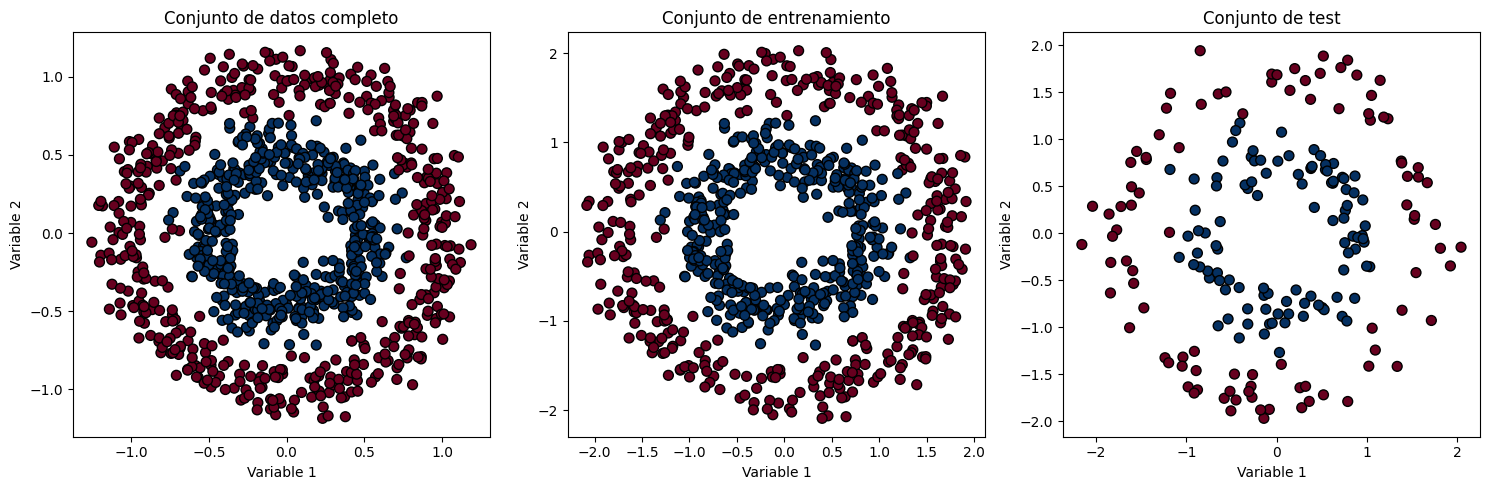

In [22]:
# Generar un conjunto de datos con dos círculos concéntricos
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=33)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Configurar subgráficos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Subplot para el conjunto de datos completo
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', marker='o', s=50)
axs[0].set_title("Conjunto de datos completo")
axs[0].set_xlabel("Variable 1")
axs[0].set_ylabel("Variable 2")

# Subplot para el conjunto de entrenamiento
axs[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k', marker='o', s=50)
axs[1].set_title("Conjunto de entrenamiento")
axs[1].set_xlabel("Variable 1")
axs[1].set_ylabel("Variable 2")

# Subplot para el conjunto de prueba
axs[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k', marker='o', s=50)
axs[2].set_title("Conjunto de test")
axs[2].set_xlabel("Variable 1")
axs[2].set_ylabel("Variable 2")

plt.tight_layout()
plt.show()

In [23]:
# Crear el modelo
model = Sequential()
model.add(Dense(16, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

np.random.seed(94) # para que sea reproducible

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/10
25/25 [==============================] - 1s 11ms/step - loss: 0.6506 - accuracy: 0.5050 - val_loss: 0.6537 - val_accuracy: 0.4900
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.5050 - val_loss: 0.6463 - val_accuracy: 0.4900
Epoch 3/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.5100 - val_loss: 0.6386 - val_accuracy: 0.4950
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.5188 - val_loss: 0.6306 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.5238 - val_loss: 0.6232 - val_accuracy: 0.5100
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.5300 - val_loss: 0.6150 - val_accuracy: 0.5100
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6006 - accuracy: 0.5462 - val_loss: 0.6064 - val_accuracy: 0.5700
Epoch 8/10
25/25 [=

2868/2868 [==============================] - 4s 1ms/step


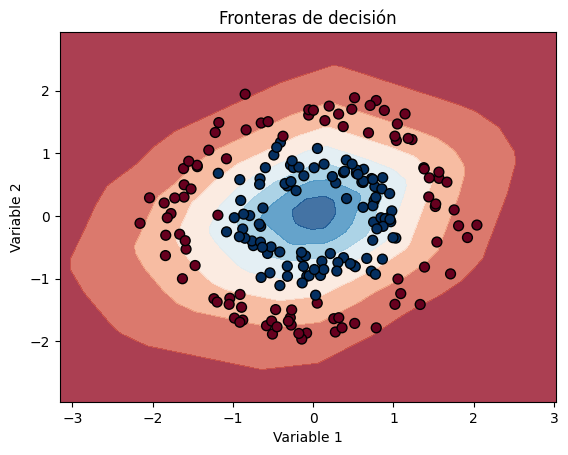

In [24]:
# Visualizar la frontera de decisión
def plot_decision_boundary(X, y, model, scaler):
    h = .02  # Tamaño de paso en la malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', marker='o', s=50)
    plt.title("Fronteras de decisión")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")
    plt.show()

# Visualizar la frontera de decisión
plot_decision_boundary(X_test, y_test, model, scaler)

Los valores de **loss** y **accuracy** son métricas que nos ayudan a evaluar el rendimiento de tu modelo en el conjunto de datos de prueba.
- Loss (Pérdida): Es una medida de cuánto se equivoca el modelo en sus predicciones. Idealmente, quieres que la pérdida sea lo más baja posible.
- Accuracy (Precisión): Es la proporción de predicciones correctas en relación con el total de predicciones. Cuanto más alto sea el valor, mejor.

La diferencia entre ambas radica en que la pérdida es una medida cuantitativa de la diferencia entre las predicciones del modelo y las verdaderas etiquetas mientras que la accuracy es una medida percentual que mide la proporción de predicciones correctas en relación con el total de predicciones.

Para obtener una evaluación más detallada, podemos utilizar otras métricas y visualizaciones, como la matriz de confusión y el informe de clasificación. Estos te proporcionarán información sobre cómo el modelo se desempeña en cada clase (positiva y negativa) y te ayudarán a identificar posibles problemas, como desequilibrios de clase.

In [25]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones a etiquetas binarias (0 o 1)
binary_predictions = (predictions > 0.5).astype(int)

# Imprimir la matriz de confusión
print('Confusion Matrix:')
print(confusion_matrix(y_test, binary_predictions))

# Imprimir el informe de clasificación
print('\nClassification Report:')
print(classification_report(y_test, binary_predictions))

7/7 [==============================] - 0s 4ms/step
Confusion Matrix:
[[97  0]
 [61 42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        97
           1       1.00      0.41      0.58       103

    accuracy                           0.69       200
   macro avg       0.81      0.70      0.67       200
weighted avg       0.81      0.69      0.67       200



## 🏋🏻 Ejercicio

En este ejercicio deberás replicar el ejemplo básico de clasificación binaria utilizando una red neuronal con variables numéricas. En este caso, utilizaremos el conjunto de datos de [cáncer de mama de sklearn](https://archive.ics.uci.edu/dataset/14/breast+cancer) como ejemplo:

In [4]:
# Cargar el conjunto de datos de cáncer de mama
data = load_breast_cancer()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [5]:
# No haría falta, pero por tener una idea de los datos
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [6]:
X = data.data
y = data.target
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)
# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Crear el modelo
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
np.random.seed(0) # para que sea reproducible
# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)
# Convertir las predicciones a etiquetas binarias (0 o 1)
binary_predictions = (predictions > 0.5).astype(int)
# Comparar predicciones con etiquetas reales
from sklearn.metrics import confusion_matrix, classification_report
print('Confusion Matrix:')
print(confusion_matrix(y_test, binary_predictions))
print('\nClassification Report:')
print(classification_report(y_test, binary_predictions))

Epoch 1/10
15/15 [==============================] - 1s 19ms/step - loss: 0.7240 - accuracy: 0.5758 - val_loss: 0.5900 - val_accuracy: 0.6579
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 0.5208 - accuracy: 0.7451 - val_loss: 0.4580 - val_accuracy: 0.8421
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 0.3995 - accuracy: 0.8527 - val_loss: 0.3744 - val_accuracy: 0.8596
Epoch 4/10
15/15 [==============================] - 0s 6ms/step - loss: 0.3227 - accuracy: 0.8923 - val_loss: 0.3203 - val_accuracy: 0.8684
Epoch 5/10
15/15 [==============================] - 0s 6ms/step - loss: 0.2727 - accuracy: 0.9231 - val_loss: 0.2834 - val_accuracy: 0.9123
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: 0.2379 - accuracy: 0.9275 - val_loss: 0.2560 - val_accuracy: 0.9211
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: 0.2120 - accuracy: 0.9385 - val_loss: 0.2348 - val_accuracy: 0.9386
Epoch 8/10
15/15 [=

# Overfitting


Las redes neuronales sufren gran riesgo de overfitting. Una de las principales casusas es, por ejemplo, que al tener tantos parámetros si el conjunto de datos no es lo suficientemente grande éstos se adaptarán en exceso a las muestras que han visto.

Cuando las métricas muestran la siguiente tendencia:
- Loss aumenta en validation y disminuye en training
- Accuracy aumenta en training y disminuye en validation
Entonces el modelo muestra sobreajuste.

Vamos a ver un ejemplo que nos permitirá detectar cuando nuestro modelo sufre sobreajuste. Para ello utilizaremos el conjunto de [datos IMDB](https://keras.io/api/datasets/imdb/). Este conjunto de datos de IMDB (Internet Movie Database) es comúnmente utilizado en tareas de procesamiento de lenguaje natural (NLP) y clasificación de texto como primer ejemplo. Se trata de una colección de reseñas de películas recopiladas de la plataforma IMDb. Cada reseña está etiquetada como positiva o negativa, lo que lo convierte en un conjunto de datos de clasificación binaria. En total el conjunto de datos contiene 50000 reseñas de las cuales 25000 están reservadas para el entrenamiento y las restantes 25000 para la evaluación. Ambos subconjuntos se dividien al 50% en reseñas positivas y negativas. El conjunto de datos viene preinstalado en `tensorflow.keras.datasets` así que podemos descargarlo como se muestra a continuación (esto descargará unos 80MB):

In [29]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 [==============================] - 1s 0us/step


Si observamos por ejemplo la primera reseña vemos que contiene un array de números. Esto se debe a que las reseñas han sido previamente preprocesadas y son representadas por la codificacion numérica en un diccionario de las palabras que contienen.

In [30]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

Por otro lado, las etiquetas correspondientes serán 0 si las reseñas son negativas y 1 si las reseñas son positivas.

In [31]:
train_labels[0]

1

Observa que al cargar el conjunto de datos hemos utilizado el parámetro `num_words=10000`. Esto significa que se mantienen solo las 10000 palabras más frecuentes, descartando así palabras raras. Si no fijamos este límite, estaríamos por encima de las 88000 palabras únicas, lo cual impactaría en el teimpo de ejecución del modelo.

In [32]:
max([max(sequence) for sequence in train_data])

9999

Si estamos interesados en hacer la codificación inversa podemos ejecutar lo siguiente:

In [33]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]) # offset de 3 porque 0, 1 y 2 son para padding, comienzo secuencia y desconocido
decoded_review

1641221/1641221 [==============================] - 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Para poder entrenar la red neuronal necesitamos que los datos estén en un formato compatible que la red entienda. Estas listas de enteros representando las reseñas tienen longitudes variables, y las redes neuronales necesitan unas dimensiones fijas. Para unificar las dimensiones haremos un *multi-hot encoding* donde convertiremos cada array en un vector booleano de dimensión 10000. Una vez tengamos esto, ya podemos utilizar una capa `Dense` como primera capa que reciba esto como datos de entrada.

In [34]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [35]:
print(x_train.shape)
x_train[0]

(25000, 10000)


array([0., 1., 1., ..., 0., 0., 0.])

In [36]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [37]:
print(y_train.shape)
y_train

(25000,)


array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

Para seguir un proceso train-validate-test, separamos un conjunto de datos para la validación.

In [38]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 🏋🏻 Ejercicio

Define ahora el modelo utilizando dos capas densas de 32 neuronas. Entrena el modelo con 20 épocas y un tamaño de batch de 512 objetos. Utiliza el optimizador `rmsprop` y computa la `accuracy` de cada época. ¿Consideras que hay sobreajuste?

In [9]:
# Definir la arquitectura
model = Sequential([
 layers.Dense(32, activation="relu"),
 layers.Dense(32, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])
# Compilar
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])


In [10]:
np.random.seed(94)
history = model.fit(partial_x_train,
 partial_y_train,
epochs=20,
batch_size=512,
validation_data=(x_val, y_val))

NameError: name 'partial_x_train' is not defined

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model = Sequential([
 layers.Dense(16, activation="relu"),
 layers.Dense(16, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 🏋🏻 Ejercicio

Entrena de nuevo un modelo reduciendo el número de nodos en las capas densas a 4, manteniendo el resto de especificaciones indicadas. ¿Se reduce el overfitting? Compara los dos modelos generados, usando las variables `history_original` que almacena el resultado de entrenar el modelo original y `history_smaller_model` que hace lo mismo con el de tamaño reducido. Realiza lo mismo con `history_larger_model` que contendrá 512 en cada capa. ¿Varían los resultados? ¿Varía el tiempo de ejercución?

In [12]:
results

NameError: name 'results' is not defined

In [13]:
model.predict(x_test)

NameError: name 'x_test' is not defined

In [11]:
model = Sequential([
 layers.Dense(16, activation="relu"),
 layers.Dense(16, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
np.random.seed(94)
history_original = model.fit(train_data, train_labels,
 epochs=20, batch_size=512, validation_split=0.4)

NameError: name 'train_data' is not defined

In [ ]:
model = Sequential([
 layers.Dense(4, activation="relu"),
 layers.Dense(4, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
np.random.seed(94)
history_smaller_model = model.fit(
 train_data, train_labels,
 epochs=20, batch_size=512, validation_split=0.4)

In [ ]:
model = Sequential([
 layers.Dense(512, activation="relu"),
 layers.Dense(512, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
np.random.seed(94)
history_larger_model = model.fit(
 train_data, train_labels,
 epochs=20, batch_size=512, validation_split=0.4)

Ahora con los modelos entrenados, podemos realizar la comparación de los resultados:

In [41]:
# Suponiendo que tienes objetos de historial para cada modelo
history_original_dict = history_original.history
history_smaller_model_dict = history_smaller_model.history
history_larger_model_dict = history_larger_model.history

# Extraer valores de pérdida y pérdida de validación para cada modelo
loss_values_original = history_original_dict["loss"]
val_loss_values_original = history_original_dict["val_loss"]

loss_values_smaller_model = history_smaller_model_dict["loss"]
val_loss_values_smaller_model = history_smaller_model_dict["val_loss"]

loss_values_larger_model = history_larger_model_dict["loss"]
val_loss_values_larger_model = history_larger_model_dict["val_loss"]

# Graficar la pérdida de entrenamiento y validación para cada modelo
epochs = range(1, len(loss_values_original) + 1)

plt.figure(figsize=(12, 6))

# Gráfica para el modelo original
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_values_original, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_original, "b", label="Pérdida de validación")
plt.title("Modelo Original")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)

# Gráfica para el modelo más pequeño
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_values_smaller_model, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_smaller_model, "b", label="Pérdida de validación")
plt.title("Modelo más Pequeño")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)

# Gráfica para el modelo más grande
plt.subplot(1, 3, 3)
plt.plot(epochs, loss_values_larger_model, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_larger_model, "b", label="Pérdida de validación")
plt.title("Modelo más Grande")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


NameError: name 'history_original' is not defined

## Reducción de sobreajuste

La reducción de sobreajuste es una preocupación clave al desarrollar modelos de aprendizaje profundo, ya que estos pueden aprender patrones demasiado específicos de los datos de entrenamiento que no se generalizan bien a nuevos datos. Para abordar este problema, se utilizan diversas técnicas, entre las que se destacan los regularizadores y la técnica de dropout.

Los regularizadores, como L1 y L2, son métodos que penalizan los pesos del modelo durante el proceso de entrenamiento, evitando así que alcancen valores extremadamente altos. Esto ayuda a prevenir el sobreajuste al mantener los pesos del modelo en rangos más manejables.

Otra estrategia efectiva es el dropout, que consiste en "apagar" aleatoriamente un porcentaje de neuronas durante el entrenamiento. Esto fuerza al modelo a aprender de manera más robusta y a evitar depender demasiado de ciertas neuronas específicas, mejorando así la generalización del modelo.

En conjunto, estos enfoques ofrecen herramientas para mitigar el sobreajuste, permitiendo que los modelos aprendan patrones más representativos y sean más efectivos al enfrentarse a datos nunca vistos previamente.

### Regularizando los pesos

In [ ]:
model = Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002), # regularizar
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002), # regularizar
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

np.random.seed(94)
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

In [ ]:
history_original_dict = history_original.history
history_l2_reg_dict = history_l2_reg.history

# Extraer valores de pérdida y pérdida de validación para cada modelo
loss_values_original = history_original_dict["loss"]
val_loss_values_original = history_original_dict["val_loss"]

loss_values_l2_reg = history_l2_reg_dict["loss"]
val_loss_values_l2_reg = history_l2_reg_dict["val_loss"]

# Graficar la pérdida de entrenamiento y validación para cada modelo
epochs = range(1, len(loss_values_original) + 1)

plt.figure(figsize=(12, 6))

# Gráfica para el modelo original
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values_original, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_original, "b", label="Pérdida de validación")
plt.title("Modelo Original")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)  # Establecer límites del eje y entre 0 y 1

# Gráfica para el modelo con regularización L2
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values_l2_reg, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_l2_reg, "b", label="Pérdida de validación")
plt.title("Modelo con Regularización L2")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)  # Establecer límites del eje y entre 0 y 1

plt.tight_layout()
plt.show()

### Añadiendo dropout

In [ ]:
model = Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5), # dropout
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5), # dropout
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

In [ ]:
# Suponiendo que tienes objetos de historial para cada modelo
history_original_dict = history_original.history
history_dropout_dict = history_dropout.history  # Cambio de history_l2_reg a history_dropout

# Extraer valores de pérdida y pérdida de validación para cada modelo
loss_values_original = history_original_dict["loss"]
val_loss_values_original = history_original_dict["val_loss"]

loss_values_dropout = history_dropout_dict["loss"]  # Cambio de loss_values_l2_reg a loss_values_dropout
val_loss_values_dropout = history_dropout_dict["val_loss"]  # Cambio de val_loss_values_l2_reg a val_loss_values_dropout

# Graficar la pérdida de entrenamiento y validación para cada modelo
epochs = range(1, len(loss_values_original) + 1)

plt.figure(figsize=(12, 6))

# Gráfica para el modelo original
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values_original, "bo", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values_original, "b", label="Pérdida de validación")
plt.title("Modelo Original")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)  # Establecer límites del eje y entre 0 y 1

# Gráfica para el modelo con Dropout
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values_dropout, "bo", label="Pérdida de entrenamiento")  # Cambio de loss_values_l2_reg a loss_values_dropout
plt.plot(epochs, val_loss_values_dropout, "b", label="Pérdida de validación")  # Cambio de val_loss_values_l2_reg a val_loss_values_dropout
plt.title("Modelo con Dropout")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.ylim(0, 1)  # Establecer límites del eje y entre 0 y 1

plt.tight_layout()
plt.show()